# Workout Data Analysis

### Introduction

If you've ever trained or practiced to reach a goal, you may have wondered at one point: "am I even making any progress?" When it comes to weightlifting, I am plagued by the nagging suspicion that I'm just spinning my wheels. Progress can be so slow that it is often hard to see. Meanwhile, the variables for success are numerous and difficult to isolate. This notebook sets out to solve both of these problems. I want to see if changes in my bodyweight or training split actually affect my gains. I also want to visualize my overall growth to feel better about myself :)

### Methodology

**Data source:** Since early 2022, I recorded every weightlifting workout I did in my iPhone's notes app. For every set in each workout, I recorded the weight and repetitions I completed. Using a personal data request from Apple, I was able to download all of these notes as .txt files.

**Key Metric: One Repetition Maximum (ORM)** 

Which requires a greater level of strength?

*Performing 3 repetitions of 200 lbs* 
                
                OR 
                
*Performing 6 repetitions of 150 lbs* 

The way to calculate this is to see which set indicates a higher One Repetition Max (ORM). ORM represents the highest amount of weight you could lift for one repetition at your current strength level. One simple formula for calculating this is as follows:

        weight × (36 / (37 - repetitions)) = ORM
        
Thus, we can answer the original question and see that the former requires more strength
        
        200 x (36 / (37 - 3)) = 211.76   
        150 x (36 / (37 - 6)) = 174.19

To get a single, cross-applicable measurement of strength, I applied this calculation to every set in this notebook. This formula begins to break down at very high rep rangers (20+), but I very rarely do sets of such high volume. 

# Setup Dataframe


## Import text files

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r"C:\Users\blake\OneDrive\Desktop\WorkoutData\iCloud Notes\Workouts"

In [3]:
# List to store file content
data = []

# Traverse through all subfolders and text files
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.txt'):  # Ensure it only reads text files
            file_path = os.path.join(root, file)
            
            # Read the content of the text file
            with open(file_path, 'r',encoding="utf8") as f:
                content = f.readlines()

            folder_name = os.path.basename(root)
            file_name = file
            data.append({'Folder': folder_name, 'File': file_name, 'Content': content})
df = pd.DataFrame(data)

In [4]:
# Extract dates
df['Extract'] = df['File'].apply(lambda x: x[-24:-5].replace('_',':'))
df['Date'] = pd.to_datetime(df['Extract'],utc=True)

# Convert to local timezone
df['Date'] = df['Date'].dt.tz_convert('US/Pacific') 
df['Date'] = df['Date'].apply(lambda x: x.replace(tzinfo=None))

# Add ordinal date for numerical calculations
df["Date_ordinal"] = df['Date'].apply(lambda x: x.toordinal())

# Sort by date
df = df.sort_values('Date')

In [5]:
### DATA CLEANING

# Remove first three entries
df = df.iloc[3:]

# Remove split planning notes
df = df.drop([380,276,295,48])

# Remove erroneous days
df = df.drop([203, 81, 112, 201])

# Remove useless columns
df.drop(["File","Extract"], axis=1, inplace=True)

## Extract the One Rep Maximums

The only lifts I will be examining in this project are: squat, bench press, deadlift, and overhead press. The first three are considered by powerlifters to be "the big three" and they can be totaled as an informal indicator of one's overall strength.

Here I use a basic pair of regex queries to find the weights and repetitions I performed on each line of the text doc. It was a natural choice to use test cases for debugging, as I could simply lift real corner-cases from the data that the function would have to interpret correctly. 

In [6]:
### Lifts examined
exercises = ["Squat","Bench","Deadlift","Overhead press"]
for i in exercises:
    df[i+'_ORM']=0

In [7]:
import re
"""Return: extract both the weight and reps as integers from single line of the text file"""
def extract_weight_reps(line):
    '''
    TEST CASES:
    
    >>> extract_weight_reps("135x5")
    (135, 5)
    
    >>> extract_weight_reps("135 x 5")
    (135, 5)
    
    >>> extract_weight_reps("135x5.75")
    (135, 6)
    
    >>> extract_weight_reps("44.75x5")
    (45, 5)
    
    >>> extract_weight_reps("175x7 (last time 165x8)")
    (175, 7)
    
    >>> extract_weight_reps("185x2 F on 3")
    (185, 2)
    
    >>> extract_weight_reps("SS 25x7")
    (25, 7)
    
    >>> extract_weight_reps("70x2+ 45x2 Yikes")
    (70, 2)
    
    >>> extract_weight_reps("120x5 - 90x4")
    (120, 5)
    
    >>> extract_weight_reps("120x5 - 90x4 - 30x5")
    (120, 5)
    
    >>> extract_weight_reps("135x2.5 (not full 3rd)")
    (135, 2)
    
    >>> extract_weight_reps("200x1 (fail on 2)")
    (200, 1)
    
    >>> extract_weight_reps("5 set 95")
    (0, 0)
    
    
    >>> extract_weight_reps("205 x F")
    (0, 0)
    
    '''
    weight = 1
    reps = 1
    
    split = line.split('x')
    
    # no 'x' case
    if len(split) == 1:
        return 0, 0
    
    # simple case (should handle dropsets too?)
    if len(split) > 1:
        a = split[0].strip()
        b = split[1].strip()
        w = re.findall(r"[\d,.]{1,}$",a)
        r = re.findall(r"^[\d,.]{1,}",b)
        
        if len(w) == 0 or len(r) == 0:
            return 0, 0
        
        weight = round(float(w[0]))
        reps = round(float(r[0]))
    return weight, reps

In [8]:
### TESTING
import doctest
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=14)

In [9]:
def get_clean(lift,content):
    """Return: list of sets for particular lift. 
    Returns None if no sets were done for that lift"""
    start_index = None
    end_index = None
    for i, item in enumerate(content):
        if lift in item:
            #print(lift)
            start_index = i
        
        elif item == "\n" and start_index != None and i != start_index + 1:
            
            ## check to make sure it's not a linebreak after a comment at start of lift
            ## code: skip this if there wasn't a #x# lift in the last line
            if not re.search(r'\dx\d',content[i-1]+content[i-2]):
                continue
                
            end_index = i
            break
            
    ## handle not finding lift
    if start_index == None:
        return None
    ## removes front/back whitespaces, 
    clean = [i.strip() for i in content[start_index+1:end_index]]
    return clean

In [10]:
def find_ORM(lift, content):
    """Return: the highest ORM for a certain lift within a certain workout's contents"""
    
    #extract sets done for a lift
    clean = get_clean(lift,content)
    
    ## handle not finding any sets
    if clean == None:
        return None
        
    ## formula: weight × (36 / (37 - reps))
    top = 0
    for i in clean:
        weight, reps = extract_weight_reps(i)
        
        ### except high rep sets
        if reps > 15:
            continue

        ORM = weight * (36/(37 - reps))
        if ORM > top:
            top = ORM
    return top

In [11]:
### fill the ORMs

for index, row in df.iterrows():
    for i in exercises:
        ORM = find_ORM(i, row['Content'])
        setit = i + '_ORM'
        df.at[index,setit] = ORM

# ORM Graphs

Here are the initial graphs of my one repetition maximums for each workout I did since 2022. Thankfully, the trends for all of the lifts are clearly positive, even if they fluctuate quite a bit week-to-week. 

There is quite a bit of fluctuation on my squat compared to the other lifts, which is not a surprise to me. This is likely due to a recurring lower back injury that would come and go as I ramped up my squatting. 

Also, do note that I took almost a year-long break from deadlifting starting in mid 2023. This, too, was due to the same lower back issues.

In [12]:
def graph_ORMs(lift):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(12,8))
    
    date = df[f'Date']
    ORM = df[f'{lift}_ORM']
    plt.scatter(date,ORM)
    
    plt.ylabel("Weight (lbs)")
    plt.xlabel("Date")
    
    ## Change date formatting
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

Text(0.5, 1.0, "Blake's Bench Press ORMs from 2022-2024")

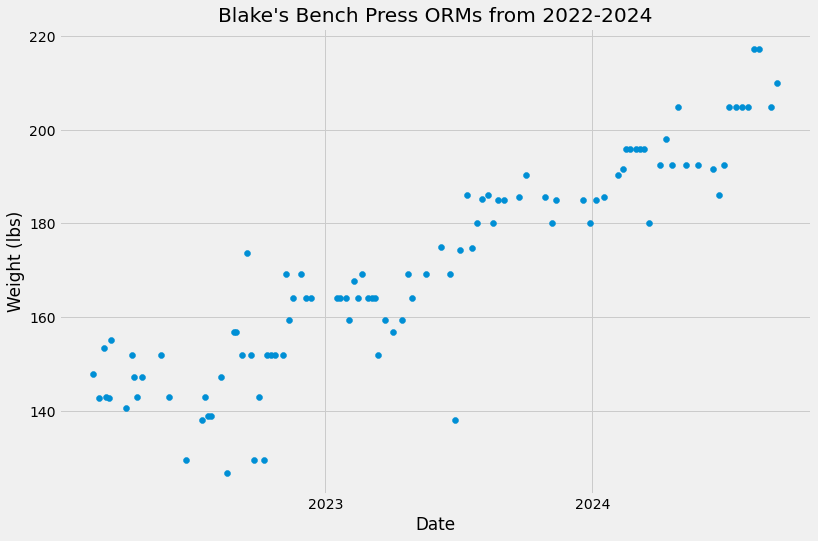

In [13]:
graph_ORMs("Bench")
plt.title(f"Blake's Bench Press ORMs from 2022-2024")

Text(0.5, 1.0, "Blake's Deadlift ORMs from 2022-2024")

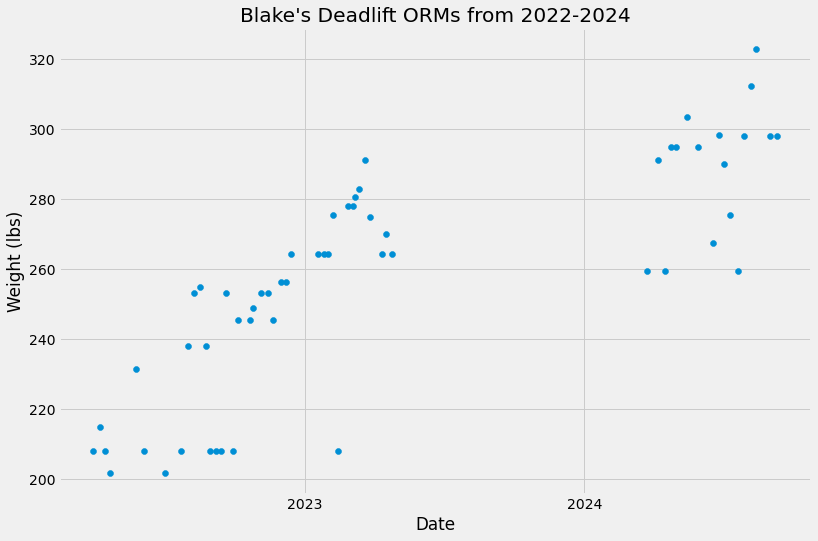

In [14]:
graph_ORMs("Deadlift")
plt.title(f"Blake's Deadlift ORMs from 2022-2024")

Text(0.5, 1.0, "Blake's Squat ORMs from 2022-2024")

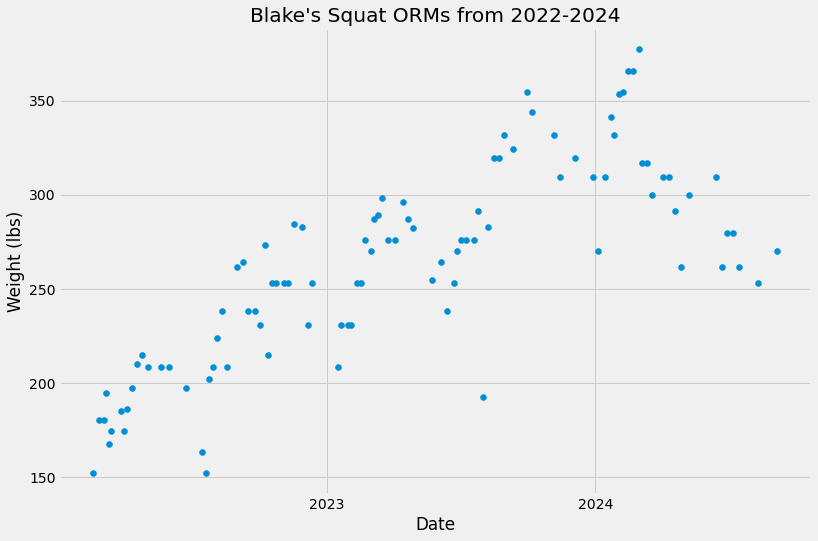

In [15]:
graph_ORMs("Squat")
plt.title(f"Blake's Squat ORMs from 2022-2024")

Text(0.5, 1.0, "Blake's Overhead Press ORMs from 2022-2024")

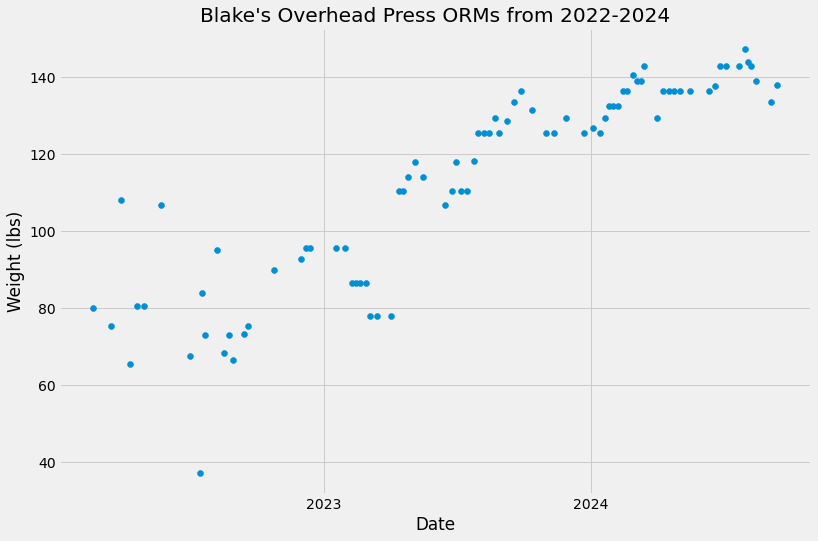

In [16]:
graph_ORMs("Overhead press")
plt.title(f"Blake's Overhead Press ORMs from 2022-2024")

# KPIs

In [79]:
span = (max(df['Date']) - min(df['Date'])).days
n = len(df)
dates_sorted = df['Date'].sort_values()



print(f"Number of workouts: {n} \n")

print(f"Days since start of data collection: {span} days \n")

print(f"Average workouts per week: {np.round(n/(span/7), 3)} \n")

print(f"Longest break between workouts: {dates_sorted.diff().max().days} days \n")

print(f"Longest break was from {dates_sorted[dates_sorted.diff().idxmax()-1].date()} to {dates_sorted[dates_sorted.diff().idxmax()].date()}")

Number of workouts: 380 

Days since start of data collection: 942 days 

Average workouts per week: 2.824 

Longest break between workouts: 31 days 

Longest break was from 2022-12-07 to 2023-01-16


In [188]:
import ipywidgets as widgets
from ipywidgets import Layout


### update the plot as the widget is changed
def update_plot(date_range):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(12,8))
    plt.title("Number of Workouts per Month")
    plt.ylabel("Workouts per Month")
    getem = by_month.loc[date_range[0]:date_range[1]]
    plt.plot(getem["Folder"])
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    


    
### create the slider widget
dates = df["Date"]
options = [(i.strftime(' %b %Y '), i) for i in dates]
w = widgets.SelectionRangeSlider(
    options=options,
    index=(0, 11),
    disabled=False,
    layout=Layout(width='50%', height='80px')
)



widgets.interact(update_plot, date_range=w)

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 11), layout=Layout(height='80px…

<function __main__.update_plot(date_range)>

# Bodyweight

Starting in August 2023, I began tracking my bodyweight. I had begun my first concerted attempt to bulk up. Supposedly, eating an excessive amount of calories and protein should translate to greater strength gains overtime. 

In March 2024, I reversed course and began methodically cutting back on my calories consumed. This is also said to have the inverse effect, potentially reducing one's strength. 

This section will shed light on if these hypotheses held true for me.

*NOTE: I am excluding deadlift from this analysis, as I was not performing this lift during my entire weight-gain phase*

In [17]:
with open(r"C:\Users\blake\OneDrive\Desktop\WorkoutData\iCloud Notes\Workouts\Weight log\Weight log-2023-08-15T16_56_48Z.txt",
          'r',encoding="utf8") as f:
    content = f.readlines()
dates = []
weights = []
for i in content:
    ah = i.split(' - ')
    if len(ah) == 2:
        dates.append(pd.to_datetime(ah[0]))
        weights.append(int(''.join(filter(str.isdigit,ah[1]))[:3]))
weights = pd.DataFrame({"Dates":dates,"Weights":weights})
        

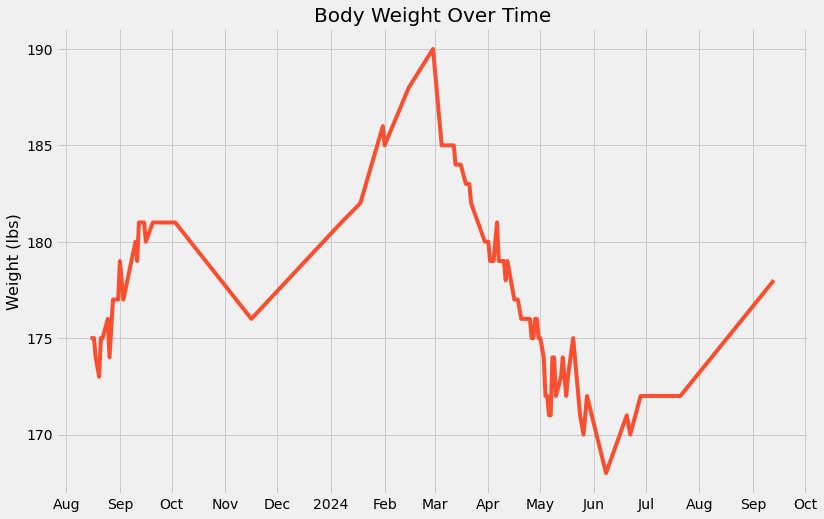

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.ylabel("Weight (lbs)", fontsize=16)
plt.title("Body Weight Over Time", fontsize=20)
plt.plot(weights['Dates'],weights['Weights'], color="C1")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

In [19]:
### Isolate my workouts to when I was tracking my weight
during_log = df[df['Date'] > weights['Dates'][0]]

In [20]:
""" Graph my bodyweight overlaid on my ORMs for a particular lift in that time period """
def weight_lift_compare(lift):
    plt.style.use('fivethirtyeight')
    fig=plt.figure(figsize=(12,8))
    
    ax2=fig.add_subplot(111, label="1")
    ax=fig.add_subplot(111, label="2", frame_on=False)

    ax2.axvline(pd.to_datetime("March 2024"), color = "C4", linestyle="dashed",linewidth=3)
    ax2.axvline(pd.to_datetime("July 2024"), color = "C2", linestyle="dashed",linewidth=3)
    ax2.plot(weights['Dates'],weights['Weights'],color="C1")
    ax.scatter(during_log['Date'],during_log[f'{lift}_ORM'],color="C6")
    

    ax.set_ylabel("Weight (lbs)", color="C6")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="C6")
    
    ax2.xaxis.set_major_locator(mdates.MonthLocator()) 
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Bodyweight (lbs)', color="C1", labelpad=10)       
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='y', colors="C1")
    ax.sharex(ax2)
    ax2.grid(False)

    
    fig.legend(["End of Bulk Phase","End of Cut Phase",'Bodyweight',f'{lift} ORM'],facecolor="White",prop={'size': 10})
    plt.title(f"{lift} vs Bodyweight")

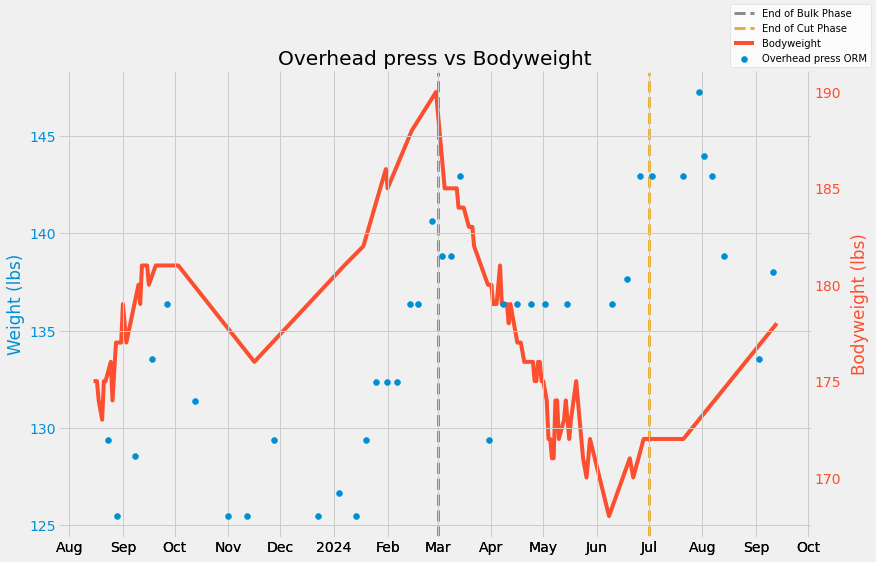

In [21]:
lift = "Overhead press"
weight_lift_compare(lift)

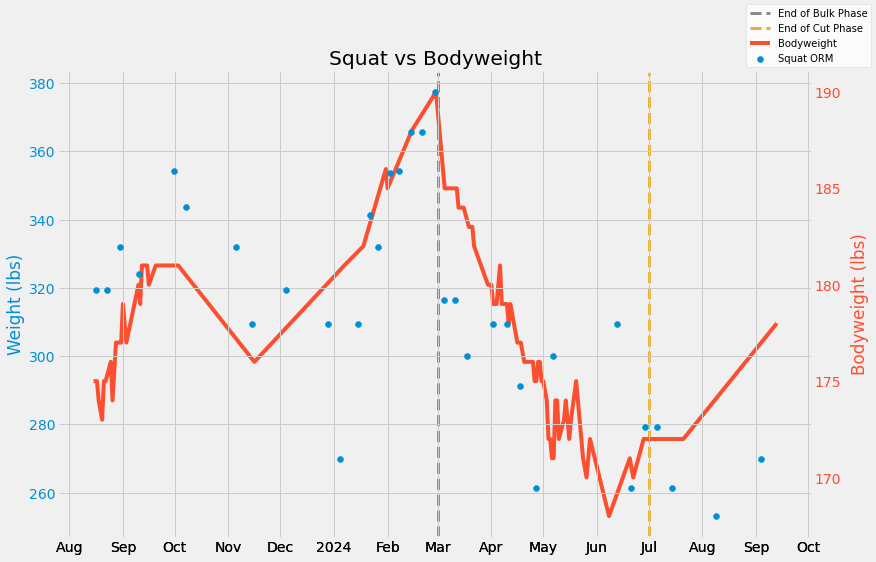

In [22]:
lift = "Squat"
weight_lift_compare(lift)

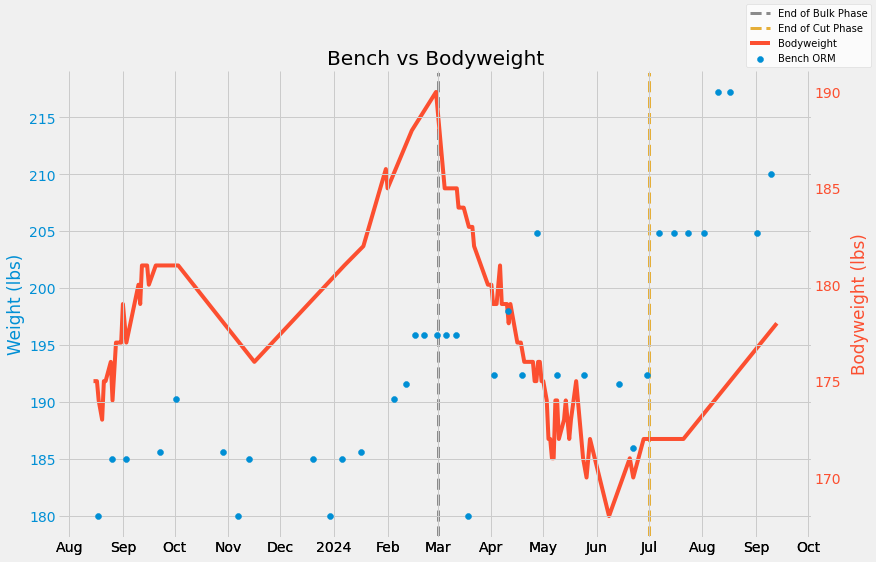

In [23]:
lift = "Bench"
weight_lift_compare(lift)

### Analysis

**Bulking Phase (August 2023 - March 2024)**

In this period, my overhead press, squat, and bench press all exhibited the same pattern. That is, growth coinciding with increases in my bodyweight. Furthermore, each observed a dip when my bodyweight dropped due to illness in November 2023. 

**Cutting Phase (March 2024 - July 2024)**

In this period, my bench press completely plateaued. Meanwhile, my overhead press immediately dropped 5-10 lbs then, too, plateaued. Finally, my squat continued to fall throughout the entire cutting phase. Overall, it seems like the cut phase coincided with a noticeable drop in my strength for these lifts. 

**Maintenance Phase (July 2024 - Present)**

My overhead and bench presses rebounded significantly once I stopped restricting my calorie intake. However, my squat did not recover at all. Perhaps this is due to the persistence of lower back issues during the cutting period. Too bad a more robust correlation can't be established, as this is only a sample size of one! :(

# Workout Splits


Another major factor in strength progression is the type of workout routine you adhere to - AKA your split. There are numerous ways to split up your strength training throughout the week -- from working every muscle on each day to having dedicated days for each muscle group. 

Here are the splits I used:

### Fullbody
**Jan 2022  -  Feb 2023**

This split simply involves working almost every muscle each time you go to the gym. During this time, I was not super consistent on adhering to a particular routine, but it roughly followed a three day cycle. 1. Squat/Bench Press 2.Deadlift/Overhead Press 3. Pullups / Triceps

### PPL1
**Feb 2023  -  Apr 2023**

This was my first attempt at a Push-Pull-Legs (PPL) split. This involves working all your pushing muscles (chest, shoulders, triceps) on one day, then all your pulling muscles (back, biceps), then finally a dedicated leg day. I followed the same routine for each muscle group each day, i.e. not alternating between a Push 1 and a Push 2 routine.

### BALC
**Apr 2023  -  Mar 2024**

This is the Back-Arms-Legs-Chest routine. I quickly felt that the PPL1 routine was unbalanced: training my legs too frequently and forcing me to train too many muscles on the same day. Thus, I split up push day into arms and chest to allow myself to train shoulders and chest on different days. It also gives me more recovery time between leg days.

### PPL2
**Mar 2024  -  Aug 2024**

I returned to the Push-Pull-Legs (PPL) split with a new strategy: alternating the routine for each day. That is, I had a Push 1 and a Push 2 day, as well as a Legs 1 & 2 and a Pull 1 & 2. This was supposed to help balance out the routine and prevent overtraining of specific muscles and neglect of others.

### Arnold Split
**Aug 2024  -  Present**

This split is similar to the PPL2 in that it involves a 3-day alternating breakdown: Chest/Back - Arms - Legs. Giving arms a dedicated day should help them improve faster. Not much changes for my leg day routine at all, though.


In [34]:
#### Define the date ranges for the different splits manually
splits = {
"fullbody1" : (pd.to_datetime('1/27/2022'), pd.to_datetime('2/8/2023')),
"PPL1" : (pd.to_datetime('2/9/2023'), pd.to_datetime('4/6/2023')),
"BALC" : (pd.to_datetime('4/7/2023'), pd.to_datetime('3/17/2024')),
"PPL2" : (pd.to_datetime('3/18/2024'), pd.to_datetime('8/25/2024')),
"Arnold" : (pd.to_datetime('8/26/2024'), pd.to_datetime('9/15/2024'))}

In [35]:
### Add the splits to each row of the dataset
splits_index = pd.IntervalIndex.from_tuples(splits.values())
split_names = list(splits.keys())
df['Split'] = splits_index.get_indexer(df['Date'])
df['Split'] = df['Split'].map(lambda i: split_names[i] if i != -1 else 'Out of Range')

In [36]:
from matplotlib.pyplot import cm

"""Visually adds highlights to the graph for the different splits"""
def add_splits():
    plt.style.use('fivethirtyeight')
    color = iter(cm.rainbow(np.linspace(0, 1, 5)))
    for i in splits:
        c = next(color)
        plt.axvspan(splits[i][0],splits[i][1],label=i, alpha=0.2, color=c)
    
def split_history(lift):
    graph_ORMs(f"{lift}")
    plt.title(f"Splits History - {lift} ", fontsize=24)
    
    add_splits()
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.sharex(ax)
    
    plt.legend(split_names + [f"{lift} ORMs"], facecolor="White")

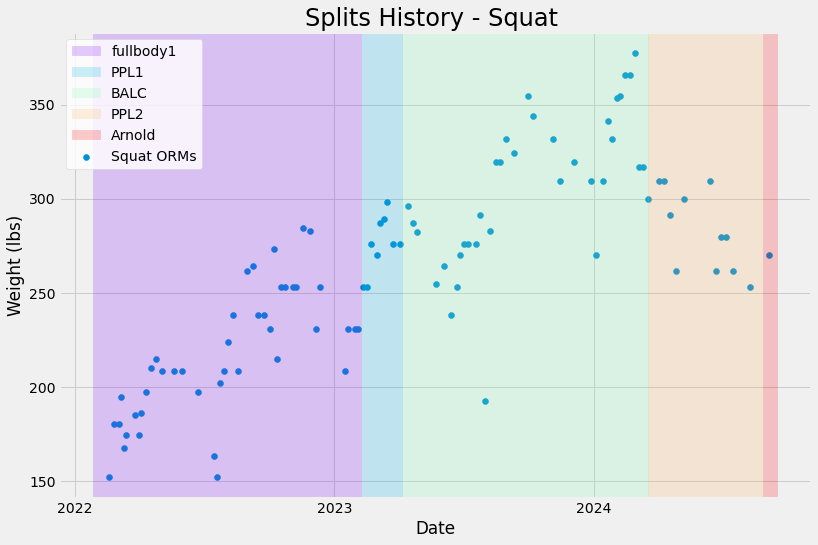

In [37]:
split_history("Squat")

In [28]:
""" graphs the line of best fit for the whole lift. Optionally, graphs one specifically
    within the date range of a particular split """
def graph_best_fit(lift, split=None):
    
    if split:
        cond = (df[f"{lift}_ORM"]>0) & (df["Split"] == split)
    else:
        cond = df[f"{lift}_ORM"]>0
        
    date = df[cond]["Date_ordinal"]
    ORMs = df[cond][f"{lift}_ORM"]
    coeffs = np.polyfit(date, ORMs, 1)
    func = np.poly1d(coeffs)
    y = func(np.unique(date))
    
    plt.plot(df[cond]["Date"], y, label=split)

In [29]:
""" graphs a line of best fit for each split for a particular lift """
def best_fit_whole_lift(lift):
    graph_ORMs(lift)
    for i in splits.keys():  
        graph_best_fit(lift, i)
    plt.title(f"Rates of Improvement by Split - {lift} ", fontsize=24)
    ax = plt.gca()
    plt.legend(split_names + [f"{lift} ORMs"], facecolor="White")
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.sharex(ax)

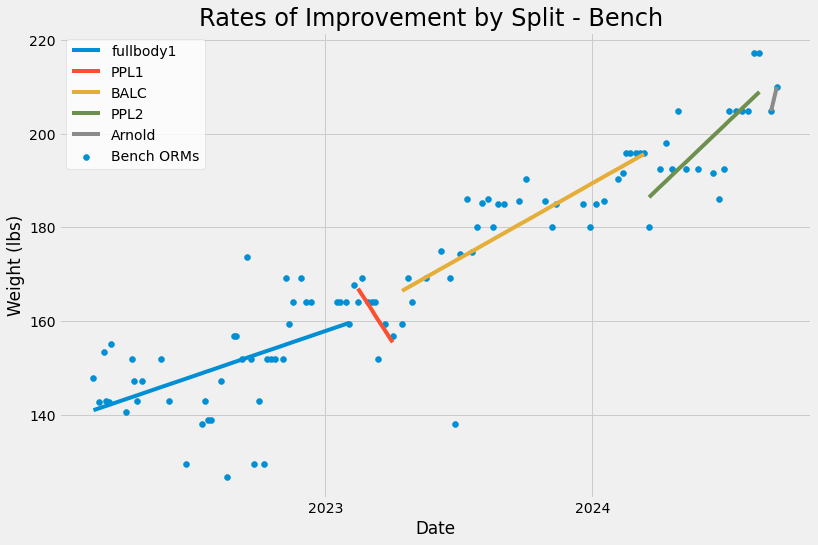

In [30]:
best_fit_whole_lift("Bench")

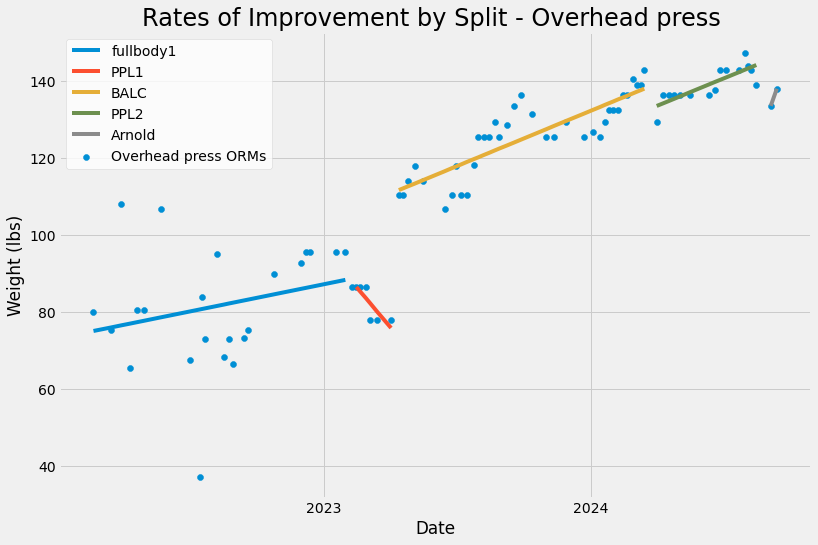

In [31]:
best_fit_whole_lift("Overhead press")

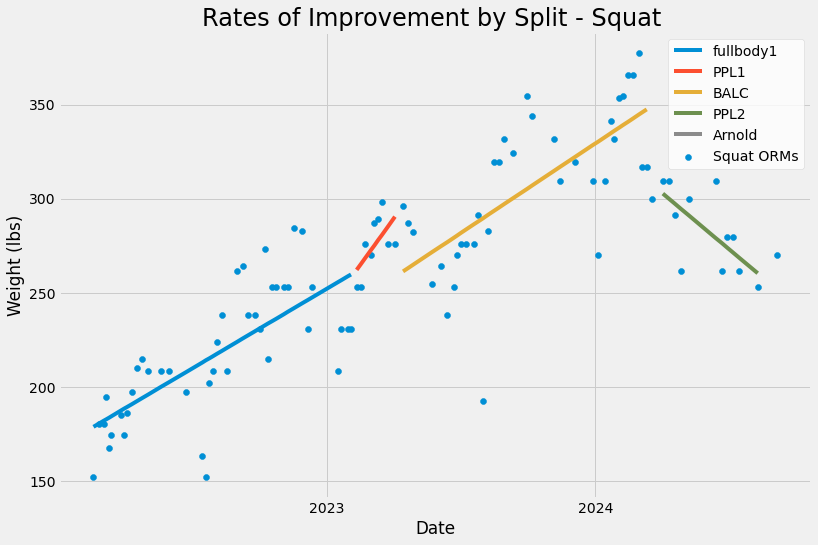

In [32]:
best_fit_whole_lift("Squat")

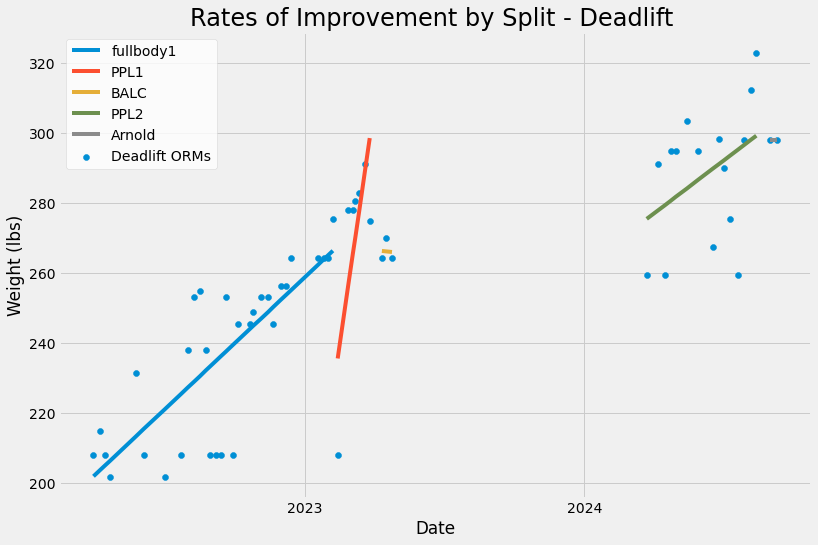

In [33]:
best_fit_whole_lift("Deadlift")

### Analysis

I'll break down my analysis by exercise.

**Bench Press**

The rate of improvement for my bench press only seems to increase over time, with the exception of the PPL1 split. This makes sense, because my main issue with the PPL1 split was its push day being too crowded, leaving little time or energy for my chest. Aside from that, the BALC & PPL2 splits afforded consistent growth.

**Overhead Press**

Before the BALC split, I trained this exercise pretty infrequently, so growth was almost non-existant. It even dropped during PPL1 due to the same issue of an overcrowded push day. However, as it became a staple exercise for me, growth became consistent regardless of split.

**Squat**

Squat showed solid rate of growth until PPL2, where it began to dip. At first, I was surprised to see growth continue to trend upward during BALC when the training frequency for legs decreased. However, note that I stopped doing deadlift at that time, freeing up more leg recovery time for squats. Reintroducing deadlifts in PPL2 may have contributed to my squat's decline.

**Deadlift**

The graph for this looks a little ugly due to the large gap in time. However, this exercise showed a solid rate of growth regardless of split. PPL1 looks like it shows a large rate of growth, but that is just due to a very low outlier at the start of the split.

**OVERALL**

It looks like workout split has little effect on growth for any of these lifts. The only exceptions were when a split was clearly not well-balanced (such as PPL1's push day) or when a major new source of fatigue is introduced (such as deadlifts in PPL2 reducing my squat). 

# Overall Strength

I was curious to see what a more general measure of my overall strength would look like when graphed against bodyweight and workout split. To calculate my overall strenght, I used the standard powerlifting metric of simply adding your highest lifts for squat, deadlift, and bench press. 

In [40]:
""" Calculates my overall strength on any given date. 

    Strength = Squat_ORM + Deadlift_ORM + Benchpress_ORM
    
    Input: pandas datetime
    Output: float
    """
def overall_strength(date):
    total = 0
    lifts = ["Squat","Bench","Deadlift"]
    for i in lifts:
        total += most_recent_ORM(i, date)
    return total
    
def most_recent_ORM(lift, date):
    ### get list of ORMs indexed by date
    lifts = df[f"{lift}_ORM"]
    lifts.index = df["Date"]
    lifts.dropna(inplace=True)
    
    # find and return ORM of most recent occurence of lift
    iloc_idx = lifts.index.get_indexer([date], method='nearest')
    return lifts[iloc_idx][0]

In [41]:
""" Graphs overall strength. Can set a specific datetime range. Can overlay with splits or bodyweight"""
def graph_overall(dates=None, splits=False, bodyweight=False):
    if dates == None:
        dates = pd.date_range(start=min(df['Date']), end=max(df['Date']))
        
    

    fig = plt.figure(figsize=(12,8))
    
    
    ax=fig.add_subplot(111,label="1")
    ax.set_ylabel("Overall Strength")
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
    
    
    if splits:
        add_splits()
        plt.legend(facecolor="White")
        plt.title("Overall Strength vs Splits", fontsize=24)
    elif bodyweight:
        ax2=fig.add_subplot(111,label="2",frame_on=False)
        ax2.plot(weights['Dates'],weights['Weights'],color="C1")
        dates = weights["Dates"]
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Bodyweight (lbs)', color="C1", labelpad=10)       
        ax2.yaxis.set_label_position('right') 
        ax2.tick_params(axis='y', colors="C1")
        ax2.xaxis.set_major_locator(mdates.MonthLocator()) 
        ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
        ax.sharex(ax2)
        ax2.grid(False)
        
    alltime = []
    for date in dates:
        alltime.append(overall_strength(date))
    ax.plot(dates, alltime)
    
    ### Formatting
    plt.title("Overall Strength - Alltime",fontsize=24)
    if splits:
        plt.title("Overall Strength by Split",fontsize=24)
    elif bodyweight:
        ax.tick_params(axis='y', colors="b")
        ax.set_ylabel("Overall Strength", color="b")
        fig.legend(['Overall Strength','Bodyweight'],facecolor="White")
        plt.title("Overall Strength vs Bodyweight",fontsize=24)
    
    

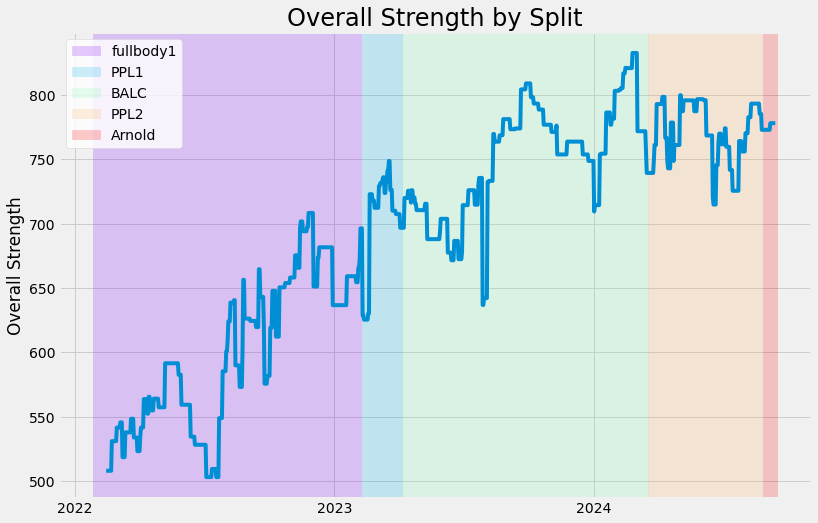

In [42]:
graph_overall(splits=True)

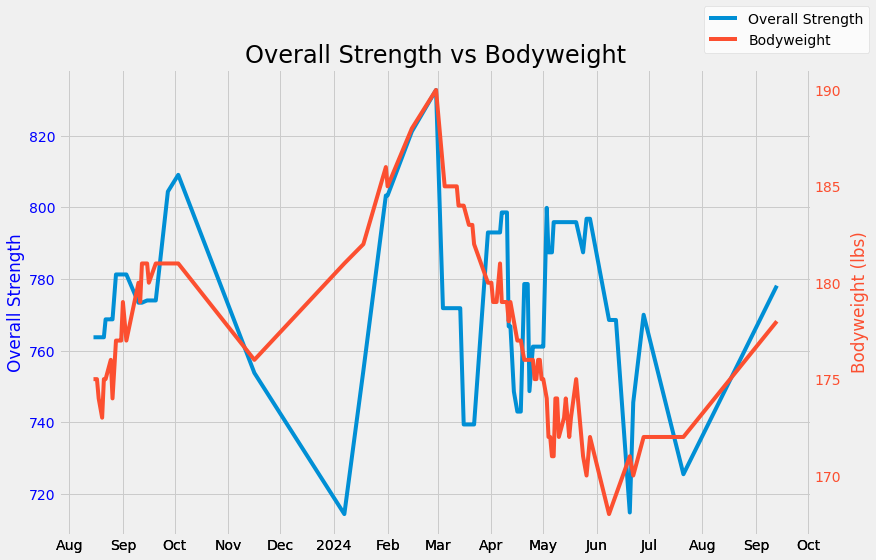

In [43]:
graph_overall(bodyweight=True)

### Analysis

In the first graph, you can see my overall strength trajectory is pretty much what you would expect: a higher rate of growth in the beginning, plateauing as you approach current day. It seems like my overall strenght is subject to regular 25 lb swings and sometimes even 50 lb shifts month over month. Still, the overall trend of growth is consistent despite these fluctuations.

As for my bodyweight graph, there are a few interesting insights. It looks like my lowest overall strength occurred during my bulking phase, due to the aforementioned illness in November. This impacted my strength for longer than expected, although it rebounded quickly in the new year. It also fell again precipitously at the start of my calorie restrictions in March, but once again quickly rebounded. 

# Export for Power BI

In [190]:
df.to_csv("Workout_Data_2024.csv")

In [192]:
weights.to_csv("Weightlog.csv")